In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp

np.random.seed(3943453)

## Gaussian Proccesses with ``tinygp``

We will use the JAX-based Gaussian Process package [`tinygp`](https://tinygp.readthedocs.io/en/stable/).

In [3]:
from tinygp import kernels, GaussianProcess

In [4]:
def plot_function(x, f_x):
    plt.plot(x, f_x, '-')
    plt.gca().set_ylim(-3, 3)
    plt.gca().set_xlabel('x')
    plt.gca().set_ylabel('f(x)')
    plt.gca().axhline(0, ls=':', color='k')

In [5]:
def build_gp(theta, X):
    
    # extract the hyperparameters
    amp = theta["amp"]
    scale = theta["scale"]
    sigma = theta["sigma"]
    
    # Construct the kernel
    kernel = amp * kernels.ExpSquared(scale)
    
    # Construct the Gaussian Process
    gp = GaussianProcess(kernel, X, diag=sigma)

    return gp

In [6]:
from jax import random

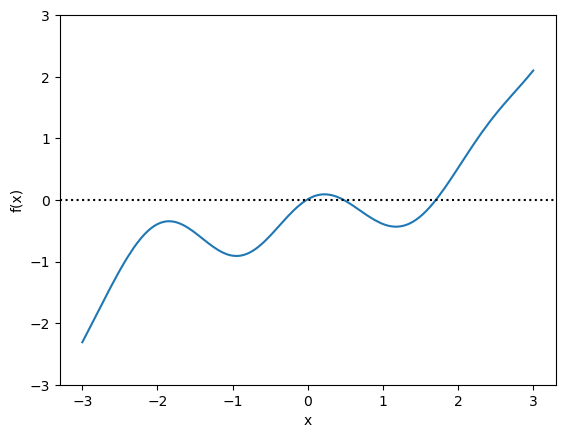

In [7]:
rng_key = random.PRNGKey(103008)

x = np.linspace(-3, 3, 1000)

theta = {'amp':2., 'scale':1., 'sigma':None}
gp = build_gp(theta, x)
f_x = gp.sample(rng_key)
plot_function(x, f_x)

We can change the look of the function by changing the hyperparameters of the GP:

- `amp`: controls the vertical amplitude of function variations
- `scale`: controls the horizontal length-scale of function variations
- `sigma`: added to the diagonal of the covariance function, adds noise to the function.
    - must be >0 for numerical stability

## Inference with Gaussian Processes 

Now let's use Gaussian Processes inside an inference problem.

First let's make some mock data of some arbitrary, somewhat complicated function,

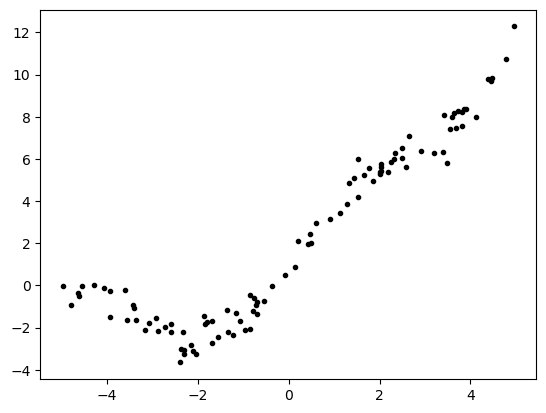

In [8]:
# sample random x-values
N = 100
x_obs = np.random.uniform(-5, 5, size=N)

# define some arbitrary functiony(x)
y = 0.5 * x_obs + 2*np.sin(x_obs/np.pi * 3) + np.exp(x_obs*0.5)

# add noise to get observed y-values
sigma = 0.5
y_obs = np.random.normal(y, sigma)

plt.plot(x_obs, y_obs, '.k')

Our goal is to find the function that describes this data. 

To do this we'll find the optimized Gaussian process hyperparameters (amplitude, scale, sigma) which describe this function. These hyperparameters must all be positive! To prevent them becoming negative during the optimization, we can take the exponential of the parameters when in our `build_gp` function:

In [9]:
def build_gp2(theta, X):

    # extract the hyperparameters
    # We want our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    amp = jnp.exp(theta["log_amp"])
    scale = jnp.exp(theta["log_scale"])
    sigma = jnp.exp(theta["log_sigma"])
    
    # Construct the kernel
    kernel = amp * kernels.ExpSquared(scale)
    
    # Construct the Gaussian Process
    gp = GaussianProcess(kernel, X, diag=sigma)

    return gp

In [10]:
def neg_log_likelihood(theta, X, y):
    gp = build_gp2(theta, X)
    return -gp.log_probability(y)

In [11]:
import jaxopt

In [12]:
solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
theta_init = {"log_amp":0., "log_scale":0., "log_sigma":0.}
soln = solver.run(theta_init, X=x_obs, y=y_obs)

In [13]:
soln

OptStep(params={'log_amp': Array(4.49600919, dtype=float64), 'log_scale': Array(1.06035845, dtype=float64), 'log_sigma': Array(-1.2728185, dtype=float64)}, state=ScipyMinimizeInfo(fun_val=Array(99.71317244, dtype=float64, weak_type=True), success=True, status=0, iter_num=14, hess_inv=Array([[ 0.91664229,  0.12977376, -0.00764316],
       [ 0.12977376,  0.02868641, -0.00134278],
       [-0.00764316, -0.00134278,  0.02120477]], dtype=float64), num_fun_eval=Array(18, dtype=int32), num_jac_eval=Array(18, dtype=int32), num_hess_eval=Array(0, dtype=int32)))

In [14]:
# build a GP using the optimized hyperparameters
gp = build_gp2(soln.params, x_obs)

# define
x_arr = np.linspace(-5, 5, 500)  # define a new x-array to evaluate the functions
cond_gp = gp.condition(y_obs, x_arr).gp # evaluate 

# evaluate the mean and variance of the best-fit GP
mean, variance = cond_gp.loc, cond_gp.variance
std = variance**0.5

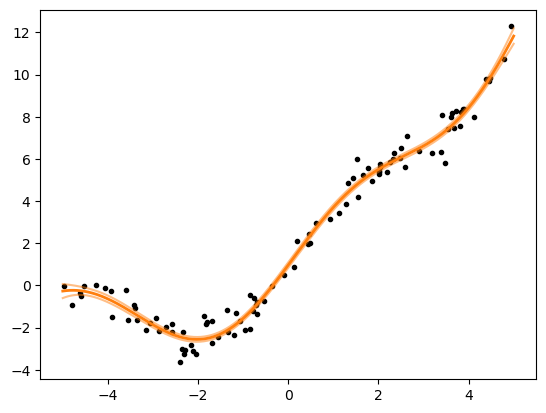

In [15]:
plt.plot(x_obs, y_obs, ".k")

# plot the inferred function
plt.plot(x_arr, mean, color="C1", lw=2)

# plot the uncertainty on the inferred function
plt.plot(x_arr, mean-std, color="C1", alpha=0.5)
plt.plot(x_arr, mean+std, color="C1", alpha=0.5)